
# ⚽ Player Position Classification (Merged Classes + Top-3 Accuracy)

This notebook compares **Logistic Regression** vs **SVM (RBF)** on:
1) **Base features only** (numeric stats from the dataset)  
2) **Composite features only**  
3) **Base + Composite features**  

It also:
- **Merges position classes** into fewer groups (to improve learnability)
- Uses **Top-1** and **Top-3 accuracy** (Top-3 is very useful for scouting)
- Uses **Group split by Player** (avoid player leakage) + **Group-aware CV** when available
- Filters **low-minutes players** (optional, if minutes column exists)
- Drops **rare classes** (configurable)

✅ Output:
- Comparison table
- Accuracy/F1 plots
- Confusion matrices for the best scenario per model
- Saved best model + feature columns (download)


In [1]:

# ============================================================
# 0) Imports
# ============================================================
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, StratifiedKFold
try:
    from sklearn.model_selection import StratifiedGroupKFold
    HAS_SGK = True
except Exception:
    HAS_SGK = False

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

import joblib, json


In [2]:

# ============================================================
# 1) Load dataset (Colab)
# ============================================================
#from google.colab import files

#uploaded = files.upload()  # upload your CSV
#csv_name = list(uploaded.keys())[0]
#print("Loaded:", csv_name)

df = pd.read_csv("C:/Users/ASUS/Desktop/players_integration.csv")
print("Shape:", df.shape)
df.head()


Shape: (10476, 235)


,Player,Team,Season_End_Year,Comp,Nation,Pos,Age,Born,Url,Cmp_Total,...,Preferred foot,Positions,Roles,main_pos,secondary_pos_1,secondary_pos_2,role_1,role_2,role_3,role_4
0,aaron anselmino,chelsea,2025,ENG-Premier League,ARG,DF,19.0,2005.0,https://fbref.com/en/players/1d87670e/Aaron-An...,0.0,...,Right,CB,"Defender +, Ball-playing defender + (Est)",CB,NaN,NaN,Defender +,Ball-playing defender +,NaN,NaN
1,aaron ciammaglichella,torino,2023,Serie A,ITA,MF,17.0,2005.0,https://fbref.com/en/players/20525799/Aaron-Ci...,0.0,...,NaN,CDM,"Deep-Lying playmaker +, Playmaker + (Est)",CDM,NaN,NaN,Deep-Lying playmaker +,Playmaker +,NaN,NaN
2,aaron ciammaglichella,torino,2024,Serie A,ITA,MF,18.0,2005.0,https://fbref.com/en/players/20525799/Aaron-Ci...,0.0,...,NaN,CDM,"Deep-Lying playmaker +, Playmaker + (Est)",CDM,NaN,NaN,Deep-Lying playmaker +,Playmaker +,NaN,NaN
3,aaron ciammaglichella,torino,2025,ITA-Serie A,ITA,MF,19.0,2005.0,https://fbref.com/en/players/20525799/Aaron-Ci...,0.0,...,NaN,CDM,"Deep-Lying playmaker +, Playmaker + (Est)",CDM,NaN,NaN,Deep-Lying playmaker +,Playmaker +,NaN,NaN
4,aaron cresswell,west ham,2021,Premier League,ENG,DF,30.0,1989.0,https://fbref.com/en/players/4f974391/Aaron-Cr...,1586.0,...,Left,"CB,LB","Fullback +, Defender +",CB,LB,NaN,Fullback +,Defender +,NaN,NaN


In [3]:

# ============================================================
# 2) Build target: primary position + MERGE classes
#    Merge into 6 groups:
#    - gk
#    - df    (cb/lb/rb/df/lwb/rwb/...)
#    - dm
#    - cm    (cm + mf)
#    - am
#    - fw    (fw/cf/ss + wings lm/lw/rm/rw)
# ============================================================

df_copy = df.copy()

# Choose position source (prefer Pos, else player_position)
if "Pos" in df_copy.columns:
    pos_raw = df_copy["Pos"].astype(str)
elif "player_position" in df_copy.columns:
    pos_raw = df_copy["player_position"].astype(str)
else:
    raise ValueError("No position column found. Expected 'Pos' or 'player_position'.")

# Primary position (before comma)
pos_primary = (
    pos_raw
    .str.lower()
    .str.strip()
    .str.split(",")
    .str[0]
    .str.strip()
)

def merge_position(p: str) -> str:
    if pd.isna(p):
        return np.nan
    p = str(p).lower().strip()
    p = p.replace(" ", "")

    # GK
    if p == "gk":
        return "gk"

    # DF group
    if p in {"cb", "lb", "rb", "lwb", "rwb", "wb", "fb", "df"}:
        return "df"
    if p.startswith("df"):
        return "df"

    # MF groups
    if p == "dm":
        return "dm"
    if p in {"cm", "mf"}:
        return "cm"
    if p == "am":
        return "am"

    # FW group (incl. wings)
    if p in {"lw", "rw", "lm", "rm", "fw", "cf", "ss"}:
        return "fw"
    if p.startswith("fw"):
        return "fw"

    # Unknown -> keep as-is (may be filtered later)
    return p

y = pos_primary.map(merge_position)

# Drop missing labels
mask_valid = y.notna() & (y != "") & (y != "nan")
df_copy = df_copy.loc[mask_valid].copy()
y = y.loc[mask_valid].copy()

print("Merged classes:", y.nunique())
display(y.value_counts())


Merged classes: 4


Pos
df    3729
cm    3208
fw    2424
gk    1115
Name: count, dtype: int64

In [5]:

# ============================================================
# 3) Filter low-minutes players (optional)
# ============================================================
def find_minutes_col(df_):
    candidates = [
        "minutes_played",
        "Min_Playing.Time",
        "Min_Playing_DF5",
        "Min_Playing_DF7",
        "Min_Playing",
        "Min",
        "Minutes"
    ]
    for c in candidates:
        if c in df_.columns:
            return c
    return None

MIN_MINS = 900  # try 600 if too strict

mins_col = find_minutes_col(df_copy)
print("Minutes column found:", mins_col)

if mins_col is not None:
    mins = pd.to_numeric(df_copy[mins_col], errors="coerce")
    keep = mins >= MIN_MINS
    df_copy = df_copy.loc[keep].copy()
    y = y.loc[df_copy.index].copy()

    print(f"After minutes filter (>= {MIN_MINS}): rows={df_copy.shape[0]}, classes={y.nunique()}")
    display(y.value_counts())
else:
    print("No minutes column found -> skipping minutes filter.")


Minutes column found: Min_Playing.Time
After minutes filter (>= 900): rows=5894, classes=4


Pos
df    2343
cm    1825
fw    1283
gk     443
Name: count, dtype: int64

In [9]:

# ============================================================
# 4) Drop rare classes
# ============================================================
MIN_CLASS_COUNT = 100  # raise/lower as needed

vc = y.value_counts()
keep_classes = vc[vc >= MIN_CLASS_COUNT].index
mask = y.isin(keep_classes)

df_copy = df_copy.loc[mask].copy()
y = y.loc[mask].copy()

print("After dropping rare classes:")
print("Rows:", df_copy.shape[0], "| Classes:", y.nunique())
display(y.value_counts())


After dropping rare classes:
Rows: 5894 | Classes: 4


Pos
df    2343
cm    1825
fw    1283
gk     443
Name: count, dtype: int64

In [11]:

# ============================================================
# 5) Define feature sets
# ============================================================
COMPOSITE_COLS = [
    "OOI", "DCI", "BPI", "SEI", "PEI",
    "PSE_FW", "PSE_MF", "PSE_DF", "PSE_FB",
    "DRI", "Aerial_Win_Rate", "Aerial_Involvement",
    "PERF_TOTAL", "MVE", "AAP", "TFS", "TVI", "CS"
]
comp_cols = [c for c in COMPOSITE_COLS if c in df_copy.columns]

DROP_ALWAYS = {
    "Player", "player_name", "Name", "id", "player_id",
    "Url", "player_url",
    "Pos", "player_position",
    "Nation", "Season", "Comp", "season",
    "transfer_notes", "Notes",
    "transfer_fee", "transfer_type", "window", "is_loan",
    "WeeklyWageGBP", "WeeklyWageEUR", "WeeklyWageUSD",
    "AnnualWageGBP", "AnnualWageEUR", "AnnualWageUSD",
    "team_name", "club_2", "league_2", "country_2",
}

numeric_cols_all = df_copy.select_dtypes(include=[np.number]).columns.tolist()
base_cols = [c for c in numeric_cols_all if (c not in DROP_ALWAYS and c not in comp_cols)]
both_cols = sorted(list(set(base_cols + comp_cols)))

print("Base numeric features:", len(base_cols))
print("Composite features found:", len(comp_cols), comp_cols)
print("Base + Composites:", len(both_cols))


Base numeric features: 218
Composite features found: 1 ['CS']
Base + Composites: 219


In [13]:

# ============================================================
# 6) Group split by Player (avoid leakage/overfit)
# ============================================================
if "Player" in df_copy.columns:
    groups = df_copy["Player"].astype(str)
    splitter = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
    tr_i, te_i = next(splitter.split(df_copy, y, groups=groups))
    train_idx = df_copy.index[tr_i]
    test_idx  = df_copy.index[te_i]
    print("Using GroupShuffleSplit by Player ✅")
else:
    from sklearn.model_selection import train_test_split
    train_idx, test_idx = train_test_split(
        df_copy.index, test_size=0.30, random_state=42, stratify=y
    )
    groups = None
    print("Player column missing -> using stratified split (no groups).")

y_train = y.loc[train_idx].copy()
y_test  = y.loc[test_idx].copy()

print("Train:", len(train_idx), "| Test:", len(test_idx))
display(y_train.value_counts())


Using GroupShuffleSplit by Player ✅
Train: 4116 | Test: 1778


Pos
df    1603
cm    1295
fw     903
gk     315
Name: count, dtype: int64

In [15]:

# ============================================================
# 7) Helpers: Top-K accuracy + group-aware CV
# ============================================================
def top_k_accuracy(model, X, y_true, k=3):
    y_true = np.array(y_true)

    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X)
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X)
        if scores.ndim == 1:
            scores = np.vstack([-scores, scores]).T
    else:
        y_pred = model.predict(X)
        return float(np.mean(y_pred == y_true))

    classes = model.classes_
    topk_idx = np.argsort(scores, axis=1)[:, -k:]
    topk_labels = classes[topk_idx]
    hits = [y_true[i] in topk_labels[i] for i in range(len(y_true))]
    return float(np.mean(hits))

def make_cv():
    if HAS_SGK and ("Player" in df_copy.columns):
        return StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42), True
    else:
        return StratifiedKFold(n_splits=5, shuffle=True, random_state=42), False


In [17]:

# ============================================================
# 8) Train + tune ONLY: LR and SVM RBF
# ============================================================
def drop_too_missing(X_train_df, X_test_df, thresh=0.60):
    miss = X_train_df.isna().mean()
    drop_cols = miss[miss > thresh].index.tolist()
    return X_train_df.drop(columns=drop_cols), X_test_df.drop(columns=drop_cols), drop_cols

def evaluate_scenario(feature_cols, scenario_name):
    X = df_copy[feature_cols].copy()
    X_train = X.loc[train_idx].copy()
    X_test  = X.loc[test_idx].copy()

    X_train, X_test, dropped = drop_too_missing(X_train, X_test, thresh=0.60)
    if dropped:
        print(f"[{scenario_name}] Dropped {len(dropped)} columns (>60% missing in train).")

    cv_obj, needs_groups = make_cv()
    groups_train = df_copy.loc[train_idx, "Player"].astype(str) if ("Player" in df_copy.columns) else None

    rows = []
    fitted_models = {}

    # ---- Logistic Regression ----
    lr_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("var", VarianceThreshold(0.0)),
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=5000, solver="lbfgs"))
    ])
    lr_grid = {
        "model__C": [0.03, 0.1, 0.3, 1, 3, 10],
        "model__class_weight": [None, "balanced"],
    }
    lr_search = GridSearchCV(lr_pipe, lr_grid, scoring="accuracy", cv=cv_obj, n_jobs=-1, refit=True)
    if needs_groups:
        lr_search.fit(X_train, y_train, groups=groups_train)
    else:
        lr_search.fit(X_train, y_train)

    best_lr = lr_search.best_estimator_
    pred_lr = best_lr.predict(X_test)

    rows.append({
        "scenario": scenario_name,
        "model": "LogReg",
        "n_features_used": X_train.shape[1],
        "cv_acc": float(lr_search.best_score_),
        "test_acc": float(np.mean(pred_lr == y_test.values)),
        "test_top3_acc": top_k_accuracy(best_lr, X_test, y_test.values, k=3),
        "test_f1_macro": float(f1_score(y_test.values, pred_lr, average="macro")),
        "test_f1_weighted": float(f1_score(y_test.values, pred_lr, average="weighted")),
        "best_params": lr_search.best_params_
    })
    fitted_models[("LogReg", scenario_name)] = (best_lr, X_train.columns.tolist())

    # ---- SVM (RBF) ----
    svm_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("var", VarianceThreshold(0.0)),
        ("scaler", StandardScaler()),
        ("model", SVC(kernel="rbf"))
    ])
    svm_grid = {
        "model__C": [0.1, 0.3, 1, 3, 10, 30, 100],
        "model__gamma": ["scale", 0.001, 0.003, 0.01, 0.03, 0.1],
        "model__class_weight": [None, "balanced"],
    }
    svm_search = GridSearchCV(svm_pipe, svm_grid, scoring="accuracy", cv=cv_obj, n_jobs=-1, refit=True)
    if needs_groups:
        svm_search.fit(X_train, y_train, groups=groups_train)
    else:
        svm_search.fit(X_train, y_train)

    best_svm = svm_search.best_estimator_
    pred_svm = best_svm.predict(X_test)

    rows.append({
        "scenario": scenario_name,
        "model": "SVM_RBF",
        "n_features_used": X_train.shape[1],
        "cv_acc": float(svm_search.best_score_),
        "test_acc": float(np.mean(pred_svm == y_test.values)),
        "test_top3_acc": top_k_accuracy(best_svm, X_test, y_test.values, k=3),
        "test_f1_macro": float(f1_score(y_test.values, pred_svm, average="macro")),
        "test_f1_weighted": float(f1_score(y_test.values, pred_svm, average="weighted")),
        "best_params": svm_search.best_params_
    })
    fitted_models[("SVM_RBF", scenario_name)] = (best_svm, X_train.columns.tolist())

    return pd.DataFrame(rows), fitted_models

scenario_defs = []
if base_cols:
    scenario_defs.append(("Base only", base_cols))
if comp_cols:
    scenario_defs.append(("Composites only", comp_cols))
if both_cols:
    scenario_defs.append(("Base + Composites", both_cols))

all_rows = []
all_models = {}

for name, cols in scenario_defs:
    print("\n" + "="*70)
    print("Scenario:", name)
    res, models = evaluate_scenario(cols, name)
    all_rows.append(res)
    all_models.update(models)

results_df = pd.concat(all_rows, ignore_index=True)
results_df = results_df.sort_values(["test_acc", "test_top3_acc", "cv_acc"], ascending=False)
results_df



Scenario: Base only

Scenario: Composites only

Scenario: Base + Composites


,scenario,model,n_features_used,cv_acc,test_acc,test_top3_acc,test_f1_macro,test_f1_weighted,best_params
1,Base only,SVM_RBF,218,0.931846,0.942070,1.000000,0.945043,0.942164,"{'model__C': 10, 'model__class_weight': None, ..."
5,Base + Composites,SVM_RBF,219,0.931846,0.942070,1.000000,0.945043,0.942164,"{'model__C': 10, 'model__class_weight': None, ..."
4,Base + Composites,LogReg,219,0.932069,0.935321,1.000000,0.937937,0.935576,"{'model__C': 0.1, 'model__class_weight': 'bala..."
0,Base only,LogReg,218,0.931789,0.931384,1.000000,0.934132,0.931619,"{'model__C': 0.3, 'model__class_weight': 'bala..."
2,Composites only,LogReg,1,0.464261,0.487627,0.999438,0.403767,0.329330,"{'model__C': 10, 'model__class_weight': None}"
3,Composites only,SVM_RBF,1,0.464261,0.487627,0.999438,0.403767,0.329330,"{'model__C': 1, 'model__class_weight': None, '..."


,scenario,model,n_features_used,cv_acc,test_acc,test_top3_acc,test_f1_macro,test_f1_weighted,best_params
1,Base only,SVM_RBF,218,0.931846,0.942070,1.000000,0.945043,0.942164,"{'model__C': 10, 'model__class_weight': None, ..."
5,Base + Composites,SVM_RBF,219,0.931846,0.942070,1.000000,0.945043,0.942164,"{'model__C': 10, 'model__class_weight': None, ..."
4,Base + Composites,LogReg,219,0.932069,0.935321,1.000000,0.937937,0.935576,"{'model__C': 0.1, 'model__class_weight': 'bala..."
0,Base only,LogReg,218,0.931789,0.931384,1.000000,0.934132,0.931619,"{'model__C': 0.3, 'model__class_weight': 'bala..."
2,Composites only,LogReg,1,0.464261,0.487627,0.999438,0.403767,0.329330,"{'model__C': 10, 'model__class_weight': None}"
3,Composites only,SVM_RBF,1,0.464261,0.487627,0.999438,0.403767,0.329330,"{'model__C': 1, 'model__class_weight': None, '..."


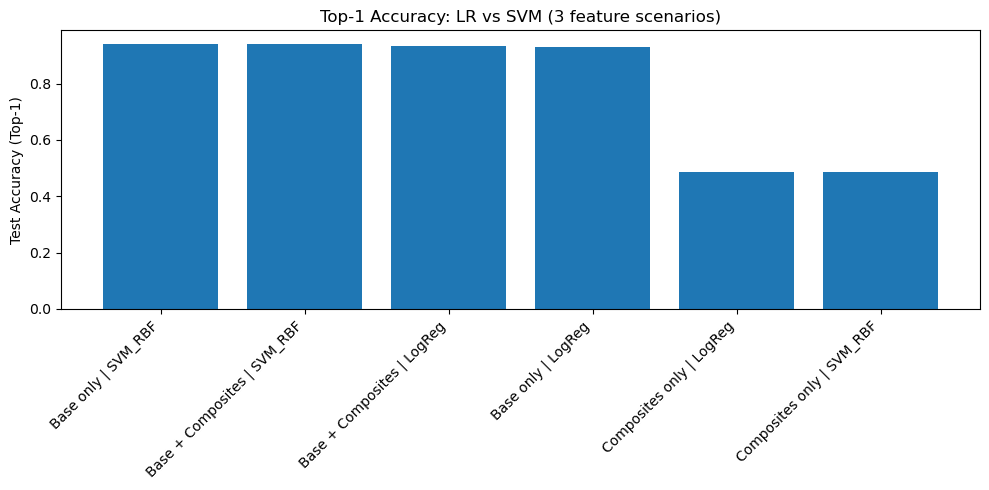

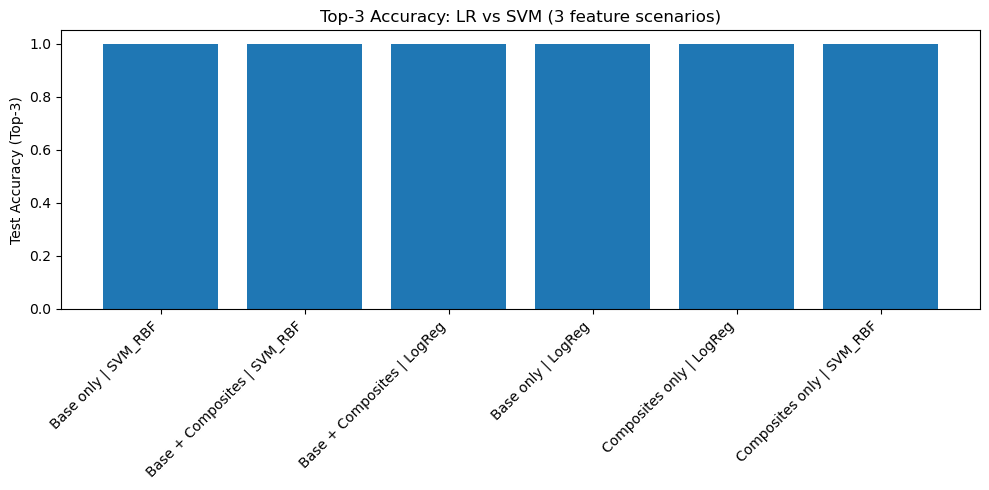

In [19]:

# ============================================================
# 9) Plot comparison (Top-1 and Top-3)
# ============================================================
display(results_df)

labels = results_df["scenario"] + " | " + results_df["model"]

plt.figure(figsize=(10,5))
plt.bar(labels, results_df["test_acc"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Test Accuracy (Top-1)")
plt.title("Top-1 Accuracy: LR vs SVM (3 feature scenarios)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.bar(labels, results_df["test_top3_acc"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Test Accuracy (Top-3)")
plt.title("Top-3 Accuracy: LR vs SVM (3 feature scenarios)")
plt.tight_layout()
plt.show()


Best LR: {'scenario': 'Base + Composites', 'test_acc': 0.9353205849268842, 'test_top3_acc': 1.0, 'best_params': {'model__C': 0.1, 'model__class_weight': 'balanced'}}
Best SVM: {'scenario': 'Base only', 'test_acc': 0.9420697412823397, 'test_top3_acc': 1.0, 'best_params': {'model__C': 10, 'model__class_weight': None, 'model__gamma': 0.001}}


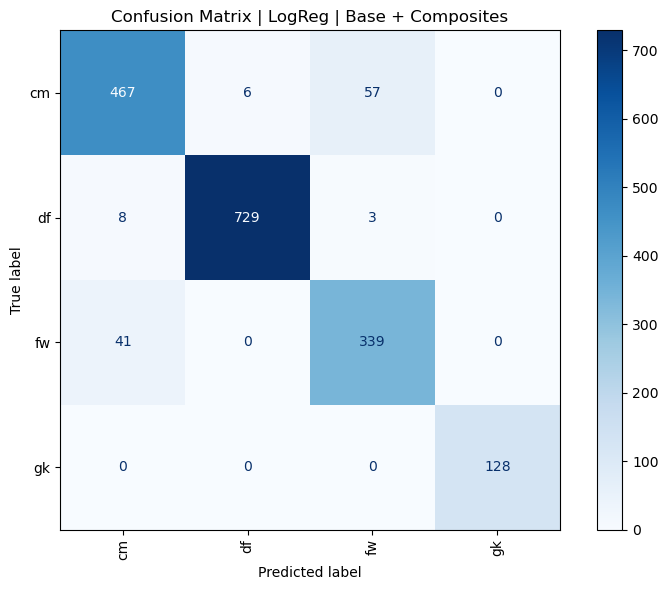

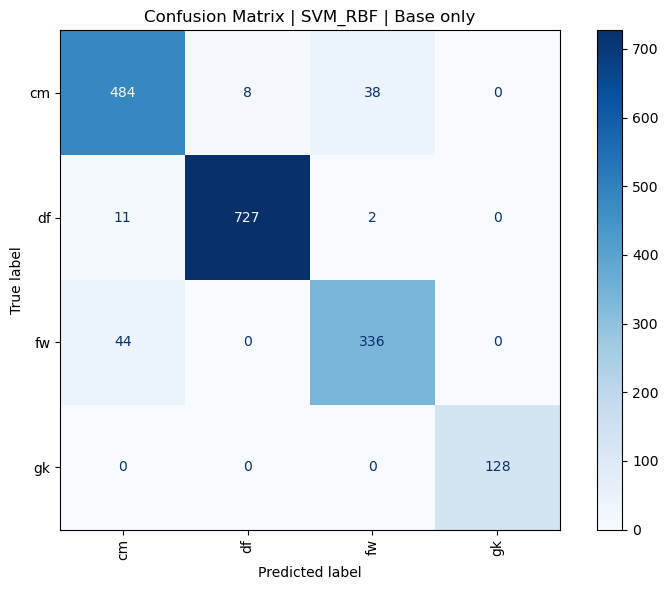

In [20]:

# ============================================================
# 10) Confusion matrices for best LR and best SVM
# ============================================================
best_lr_row = results_df[results_df["model"]=="LogReg"].iloc[0]
best_svm_row = results_df[results_df["model"]=="SVM_RBF"].iloc[0]

print("Best LR:", dict(best_lr_row[["scenario","test_acc","test_top3_acc","best_params"]]))
print("Best SVM:", dict(best_svm_row[["scenario","test_acc","test_top3_acc","best_params"]]))

def show_cm(model_name, scenario_name):
    est, cols = all_models[(model_name, scenario_name)]
    X = df_copy[cols].copy()
    X_test = X.loc[test_idx].copy()
    y_pred = est.predict(X_test)

    labels_sorted = sorted(y_test.unique())
    cm = confusion_matrix(y_test, y_pred, labels=labels_sorted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_sorted)

    fig, ax = plt.subplots(figsize=(8,6))
    disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
    plt.title(f"Confusion Matrix | {model_name} | {scenario_name}")
    plt.tight_layout()
    plt.show()

show_cm("LogReg", best_lr_row["scenario"])
show_cm("SVM_RBF", best_svm_row["scenario"])


In [23]:

# ============================================================
# 11) Save the overall best model (by Top-1, then Top-3)
# ============================================================
best_overall = results_df.sort_values(["test_acc","test_top3_acc","cv_acc"], ascending=False).iloc[0]
best_model_name = best_overall["model"]
best_scenario = best_overall["scenario"]

best_est, best_cols_used = all_models[(best_model_name, best_scenario)]

print("Saving best model:", best_model_name, "| Scenario:", best_scenario)

joblib.dump(best_est, "best_LR_or_SVM_merged_top3.joblib")
with open("best_model_columns.json","w") as f:
    json.dump({
        "merged_target": "gk/df/dm/cm/am/fw",
        "scenario": best_scenario,
        "model": best_model_name,
        "columns": best_cols_used
    }, f, indent=2)

from google.colab import files
files.download("best_LR_or_SVM_merged_top3.joblib")
files.download("best_model_columns.json")


Saving best model: SVM_RBF | Scenario: Base only


ModuleNotFoundError: No module named 'google.colab'